In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load and preprocess the text data
text_data_path = 'F:/MS Thesis/RND/BanglaText.csv'
df = pd.read_csv(text_data_path)

# Encode emotion labels for text data
label_encoder = LabelEncoder()
df['Encoded_Emotion'] = label_encoder.fit_transform(df['Emotion'])
y = df['Encoded_Emotion']

# Tokenization and Padding for Text
MAX_VOCAB_SIZE = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['Cleaned_Text'])

X = tokenizer.texts_to_sequences(df['Cleaned_Text'])
X = pad_sequences(X, maxlen=MAX_SEQ_LEN)

# Train-Test Split for Text Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# One-hot encoding for text labels
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [3]:
# Load and preprocess the voice data
X_voice = np.load('F:/MS Thesis/Research/Data/features.npy')
y_voice = np.load('F:/MS Thesis/Research/Data/labels.npy')

# Check the shape of X_voice to understand its dimensions
if len(X_voice.shape) == 2:
    X_voice = X_voice.reshape((X_voice.shape[0], X_voice.shape[1], 1))

# Encode the voice labels
label_map = {label: idx for idx, label in enumerate(np.unique(y_voice))}
y_voice = np.array([label_map[label] for label in y_voice])

# Train-Test Split for Voice Data
X_train_voice, X_temp_voice, y_train_voice, y_temp_voice = train_test_split(X_voice, y_voice, test_size=0.2, random_state=42, stratify=y_voice)
X_val_voice, X_test_voice, y_val_voice, y_test_voice = train_test_split(X_temp_voice, y_temp_voice, test_size=0.5, random_state=42, stratify=y_temp_voice)

# One-hot encoding for voice labels
y_train_voice = to_categorical(y_train_voice, num_classes=6)
y_val_voice = to_categorical(y_val_voice, num_classes=6)
y_test_voice = to_categorical(y_test_voice, num_classes=6)

E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 388ms/step - accuracy: 0.2526 - loss: 1.7112 - val_accuracy: 0.4400 - val_loss: 1.3930
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 419ms/step - accuracy: 0.5006 - loss: 1.2586 - val_accuracy: 0.6033 - val_loss: 1.0946
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - accuracy: 0.7248 - loss: 0.7550 - val_accuracy: 0.6533 - val_loss: 1.0590
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 94s 434ms/step - accuracy: 0.8574 - loss: 0.4299 - val_accuracy: 0.6417 - val_loss: 1.1238
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.9138 - loss: 0.2725 - val_accuracy: 0.6433 - val_loss: 1.2670
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 345ms/step - accuracy: 0.9342 - loss: 0.1925 - val_accuracy: 0.6467 - val_loss: 1.3496
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 385ms/step - accuracy: 0.9534 - loss: 0.1482 - val_accuracy: 0.6450 - val_loss: 1.4572
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9615 - loss: 

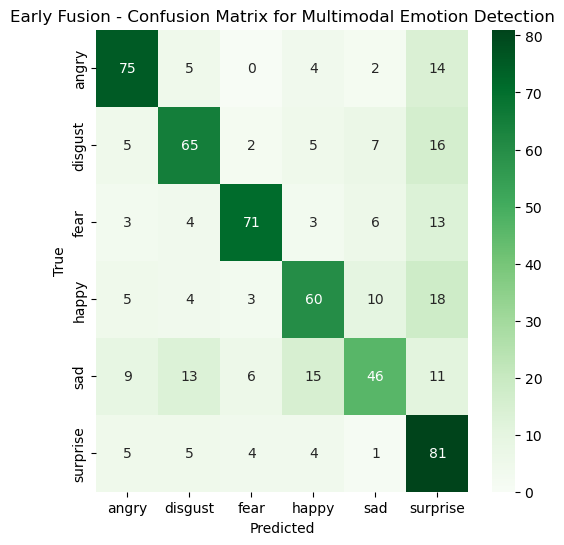

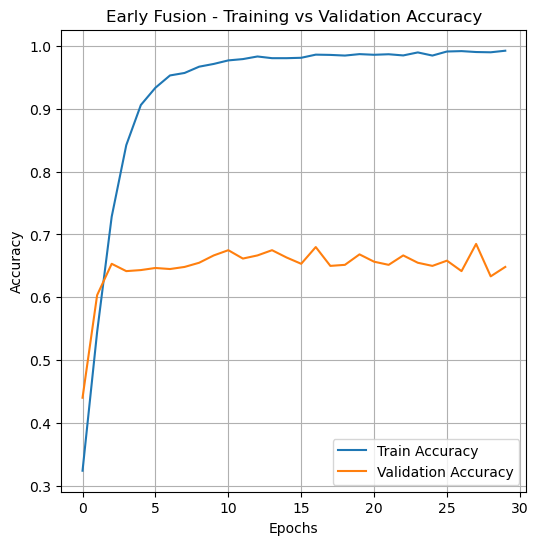

In [4]:
# Build the Early Fusion Model (Combining Text + Voice)
text_input = layers.Input(shape=(MAX_SEQ_LEN,))
voice_input = layers.Input(shape=(X_train_voice.shape[1], X_train_voice.shape[2]))

# Text Model (Bi-LSTM)
x = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
x = layers.Bidirectional(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5))(x)
x = layers.Dense(64, activation='relu')(x)

# Voice Model (CNN + Bi-LSTM)
y = layers.Conv1D(64, kernel_size=3, activation='relu')(voice_input)
y = layers.MaxPooling1D(pool_size=2)(y)
y = layers.Conv1D(128, kernel_size=3, activation='relu')(y)
y = layers.MaxPooling1D(pool_size=2)(y)
y = layers.Bidirectional(layers.LSTM(128))(y)
y = layers.Dense(64, activation='relu')(y)

# Combine the Text and Voice Model Outputs
combined = layers.concatenate([x, y])

# Fully connected layer
z = layers.Dense(64, activation='relu')(combined)

# Output layer
output = layers.Dense(6, activation='softmax')(z)  # 6 emotions

# Create the final model
model_early_fusion = models.Model(inputs=[text_input, voice_input], outputs=output)

# Compile the model
model_early_fusion.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Early Fusion model
history_early_fusion = model_early_fusion.fit(
    [X_train, X_train_voice], y_train,
    validation_data=([X_val, X_val_voice], y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the Early Fusion model
test_loss, test_acc = model_early_fusion.evaluate([X_test, X_test_voice], y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Get predictions
y_pred = model_early_fusion.predict([X_test, X_test_voice])
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Early Fusion - Confusion Matrix for Multimodal Emotion Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot Training vs. Validation Accuracy Curve
plt.figure(figsize=(6, 6))
plt.plot(history_early_fusion.history['accuracy'], label='Train Accuracy')
plt.plot(history_early_fusion.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Early Fusion - Training vs Validation Accuracy')
plt.grid(True)
plt.show()

E:\python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 261ms/step - accuracy: 0.2322 - loss: 1.7597 - val_accuracy: 0.3833 - val_loss: 1.5462
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.4537 - loss: 1.4021 - val_accuracy: 0.5567 - val_loss: 1.2228
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 248ms/step - accuracy: 0.7122 - loss: 0.9308 - val_accuracy: 0.6200 - val_loss: 1.1239
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - accuracy: 0.8057 - loss: 0.7381 - val_accuracy: 0.6233 - val_loss: 1.1424
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.8600 - loss: 0.6106 - val_accuracy: 0.6433 - val_loss: 1.0790
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.8903 - loss: 0.5313 - val_accuracy: 0.6400 - val_loss: 1.0882
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - accuracy: 0.9124 - loss: 0.4873 - val_accuracy: 0.6517 - val_loss: 1.1098
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.9279 - loss: 0

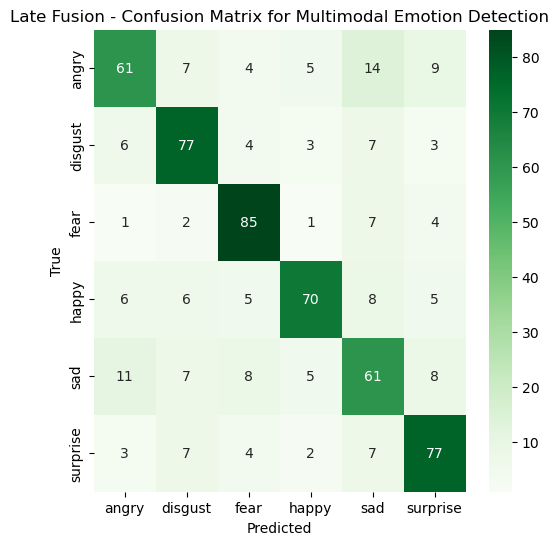

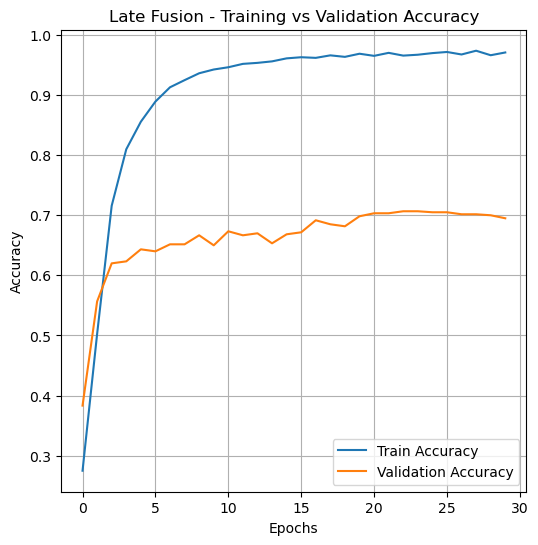

In [6]:
from tensorflow.keras.layers import average

# Inputs
text_input = layers.Input(shape=(MAX_SEQ_LEN,))
voice_input = layers.Input(shape=(X_train_voice.shape[1], X_train_voice.shape[2]))

# Text Model
x = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
x = layers.Bidirectional(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5))(x)
x = layers.Dense(64, activation='relu')(x)
text_output = layers.Dense(6, activation='softmax')(x)  # 6 emotions

# Voice Model
y = layers.Conv1D(64, kernel_size=3, activation='relu')(voice_input)
y = layers.MaxPooling1D(pool_size=2)(y)
y = layers.Conv1D(128, kernel_size=3, activation='relu')(y)
y = layers.MaxPooling1D(pool_size=2)(y)
y = layers.Bidirectional(layers.LSTM(128))(y)
y = layers.Dense(64, activation='relu')(y)
voice_output = layers.Dense(6, activation='softmax')(y)  # 6 emotions

# Combine Predictions via Averaging
combined_output = average([text_output, voice_output])

# Create Late Fusion Model
model_late_fusion = models.Model(inputs=[text_input, voice_input], outputs=combined_output)

# Compile the Late Fusion model
model_late_fusion.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Late Fusion model
history_late_fusion = model_late_fusion.fit(
    [X_train, X_train_voice], y_train,
    validation_data=([X_val, X_val_voice], y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the Late Fusion model
test_loss, test_acc = model_late_fusion.evaluate([X_test, X_test_voice], y_test)
print(f"Late Fusion Test Accuracy: {test_acc:.2f}")


# Get predictions
y_pred = model_late_fusion.predict([X_test, X_test_voice])
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification Report
print("\nLate Fusion - Classification Report:\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Late Fusion - Confusion Matrix for Multimodal Emotion Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot Training vs. Validation Accuracy Curve
plt.figure(figsize=(6, 6))
plt.plot(history_late_fusion.history['accuracy'], label='Train Accuracy')
plt.plot(history_late_fusion.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Late Fusion - Training vs Validation Accuracy')
plt.grid(True)
plt.show()

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 249ms/step - accuracy: 0.6695 - loss: 1.0528 - val_accuracy: 0.6350 - val_loss: 1.2592
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 195ms/step - accuracy: 0.9635 - loss: 0.1704 - val_accuracy: 0.6467 - val_loss: 1.3593
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - accuracy: 0.9739 - loss: 0.1193 - val_accuracy: 0.6833 - val_loss: 1.0980
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step - accuracy: 0.9722 - loss: 0.1009 - val_accuracy: 0.6800 - val_loss: 1.2402
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - accuracy: 0.9805 - loss: 0.0762 - val_accuracy: 0.6933 - val_loss: 1.1913
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.9778 - loss: 0.0750 - val_accuracy: 0.6900 - val_loss: 1.2288
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.9844 - loss: 0.0622 - val_accuracy: 0.6933 - val_loss: 1.3014
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - accuracy: 0.9852 - loss: 0

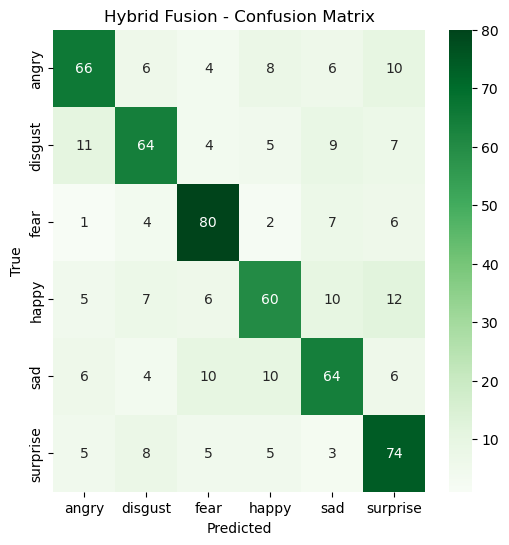

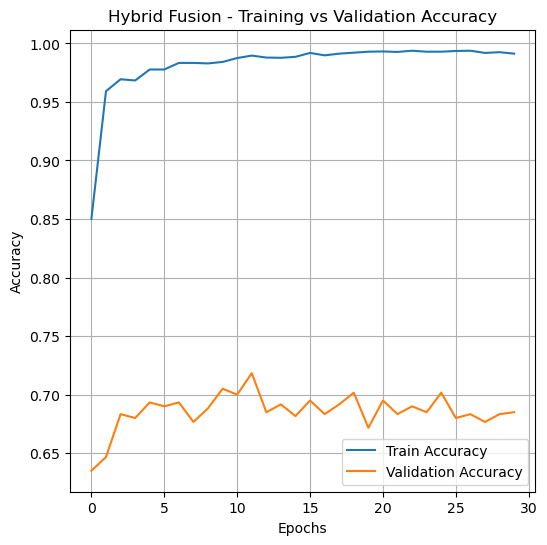

In [7]:
from tensorflow.keras.layers import concatenate

# Combine the outputs of text and voice submodels
combined_features = concatenate([x, y])

# Additional layers for Hybrid Fusion
z = layers.Dense(64, activation='relu')(combined_features)
z = layers.Dropout(0.5)(z)
hybrid_output = layers.Dense(6, activation='softmax')(z)  # 6 emotions

# Create Hybrid Fusion Model
model_hybrid_fusion = models.Model(inputs=[text_input, voice_input], outputs=hybrid_output)

# Compile the Hybrid Fusion model
model_hybrid_fusion.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Hybrid Fusion model
history_hybrid_fusion = model_hybrid_fusion.fit(
    [X_train, X_train_voice], y_train,
    validation_data=([X_val, X_val_voice], y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the Hybrid Fusion model
test_loss, test_acc = model_hybrid_fusion.evaluate([X_test, X_test_voice], y_test)
print(f"Hybrid Fusion Test Accuracy: {test_acc:.2f}")

# Get predictions
y_pred = model_hybrid_fusion.predict([X_test, X_test_voice])
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification Report
print("\nHybrid Fusion - Classification Report:\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Hybrid Fusion - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot Training vs. Validation Accuracy Curve
plt.figure(figsize=(6, 6))
plt.plot(history_hybrid_fusion.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid_fusion.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Hybrid Fusion - Training vs Validation Accuracy')
plt.grid(True)
plt.show()
